In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import gaussian_vel_reconstruction, espra



In [2]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/IN2023/sadcp.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=[f'u{z}' for z in z_sadcp])
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=[f'v{z}' for z in z_sadcp])
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

df_sadcp = pd.DataFrame({'Lon': lon_sadcp, 'Lat': lat_sadcp, 'Time': tim_sadcp})
df_sadcp = pd.concat([df_sadcp, u_sadcp.T, v_sadcp.T], axis=1)

# pd.Timestamp('2023-10-18 20:00:00')


In [3]:
df_espra = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'z', 'Time']) 
for time in pd.date_range(start='2023-10-17 18:00:00', end='2023-10-22 11:00:00', freq='12h'):
    t0 = time - pd.Timedelta(days=1)
    t1 = time + pd.Timedelta(days=1)
    
    df_data = df_sadcp[(df_sadcp['Time'] >= t0) & (df_sadcp['Time'] <= t1)]

    for z in z_sadcp:
        ui = df_data[f'u{z}']
        mask = ~np.isnan(ui)
        if np.any(mask):
            ui = ui[mask]
            vi = df_data[f'v{z}'][mask]
            xi = df_data['Lon'][mask]
            yi = df_data['Lat'][mask]
            xc, yc, w, Q, Rc, psi0 = espra(xi, yi, ui, vi) 
            df_espra.loc[len(df_espra)] = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q, 'Rc': Rc, 'psi0': psi0, 'z': z, 'Time': time}
df_espra


,xc,yc,w,Q,Rc,psi0,z,Time
0,154.378042,-37.279913,-2.282348,"[[-1.0583306256763825, 0.01228981955758548], [...",0.522307,0.361272,37,2023-10-17 18:00:00
1,154.379052,-37.303245,-2.248442,"[[-1.0404477170443764, 0.01345508961553748], [...",0.497675,0.337544,47,2023-10-17 18:00:00
2,154.380111,-37.319471,-2.261453,"[[-1.0423449996812832, 0.010347737669124446], ...",0.485998,0.331441,57,2023-10-17 18:00:00
3,154.380603,-37.322626,-2.263124,"[[-1.0361406132180457, 0.003424295612869868], ...",0.520164,0.367942,67,2023-10-17 18:00:00
4,154.382516,-37.297720,-2.143972,"[[-0.9759436918348886, 0.002118811241047446], ...",0.657435,0.519045,77,2023-10-17 18:00:00
...,...,...,...,...,...,...,...,...
743,154.094426,-39.619000,-0.808313,"[[-0.3732135450095974, 0.024579698120135343], ...",2.040032,4.410143,717,2023-10-22 06:00:00
744,154.034549,-40.781782,-0.800062,"[[-0.3768180395526645, 0.024185871391132527], ...",2.013391,4.332415,727,2023-10-22 06:00:00
745,151.875223,-77.033125,-0.688774,"[[-0.340546887246756, 0.02050067395838607], [0...",3.698213,16.585678,737,2023-10-22 06:00:00
746,152.478615,-55.638295,1.788809,"[[0.8922720944756181, -0.08011115144657821], [...",3.879717,-14.125338,747,2023-10-22 06:00:00


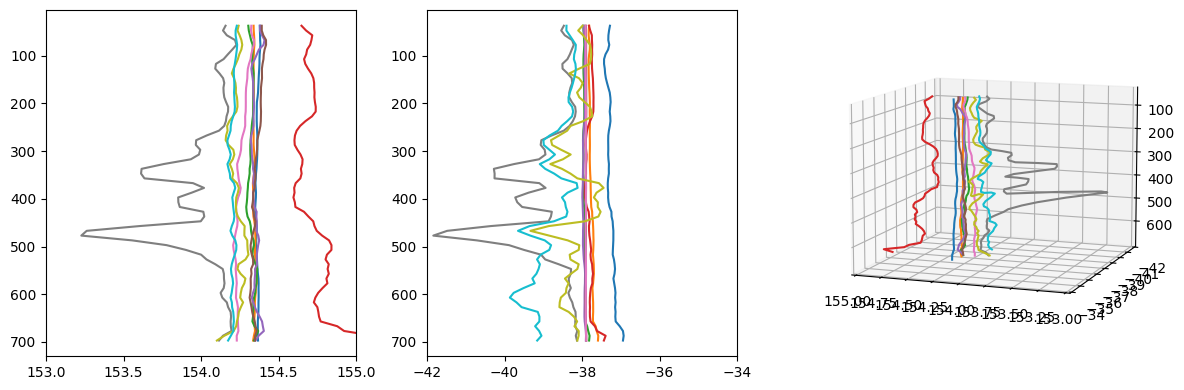

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1.2])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2], projection='3d')  # 3D plot

for t, time in enumerate(df_espra['Time'].unique()):
    df = df_espra[df_espra['Time'] == time]
    mask = df['z'] <= 700
    ax0.plot(df.loc[mask]['xc'], df.loc[mask]['z'])
    ax1.plot(df.loc[mask]['yc'], df.loc[mask]['z'])
    ax2.plot(df.loc[mask]['xc'], df.loc[mask]['yc'], df.loc[mask]['z'])

ax0.invert_yaxis(); ax1.invert_yaxis(); ax2.invert_zaxis()

ax0.set_xlim(153, 155)
ax1.set_xlim(-42, -34)
ax2.set_xlim(153, 155)
ax2.set_ylim(-42, -34)

ax2.view_init(elev=10, azim=110)

plt.tight_layout()
plt.show()


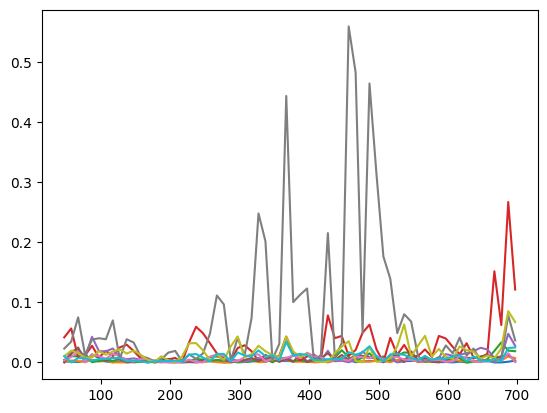

In [10]:
for time in df_espra['Time'].unique():
    df = df_espra[df_espra['Time']==time]
    df = df[df['z'] <= 700]
    plt.plot(df['z'], np.hypot(df['xc'].diff(),df['xc'].diff()))